In [1]:
import rasterio as ras
import cv2
print('cv2 version=',cv2.__version__)
from glob import glob
%pylab inline

cv2 version= 4.3.0
Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls smp | head -2

4058111_2019-09-09_RE4_3A_Analytic_3750-2000_1.tif
4058112_2019-09-09_RE4_3A_Analytic_2000-2250_1.tif


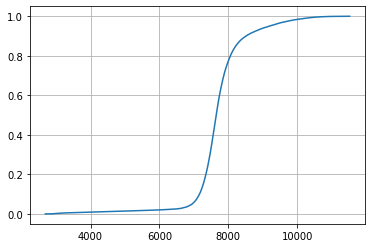

In [34]:
# plot CDF
def grey_CDF(Image):
    V=sort(Image.flatten())
    l=V.shape[0]
    P=arange(0,1,1./l)
    plot(V,P);
    grid()

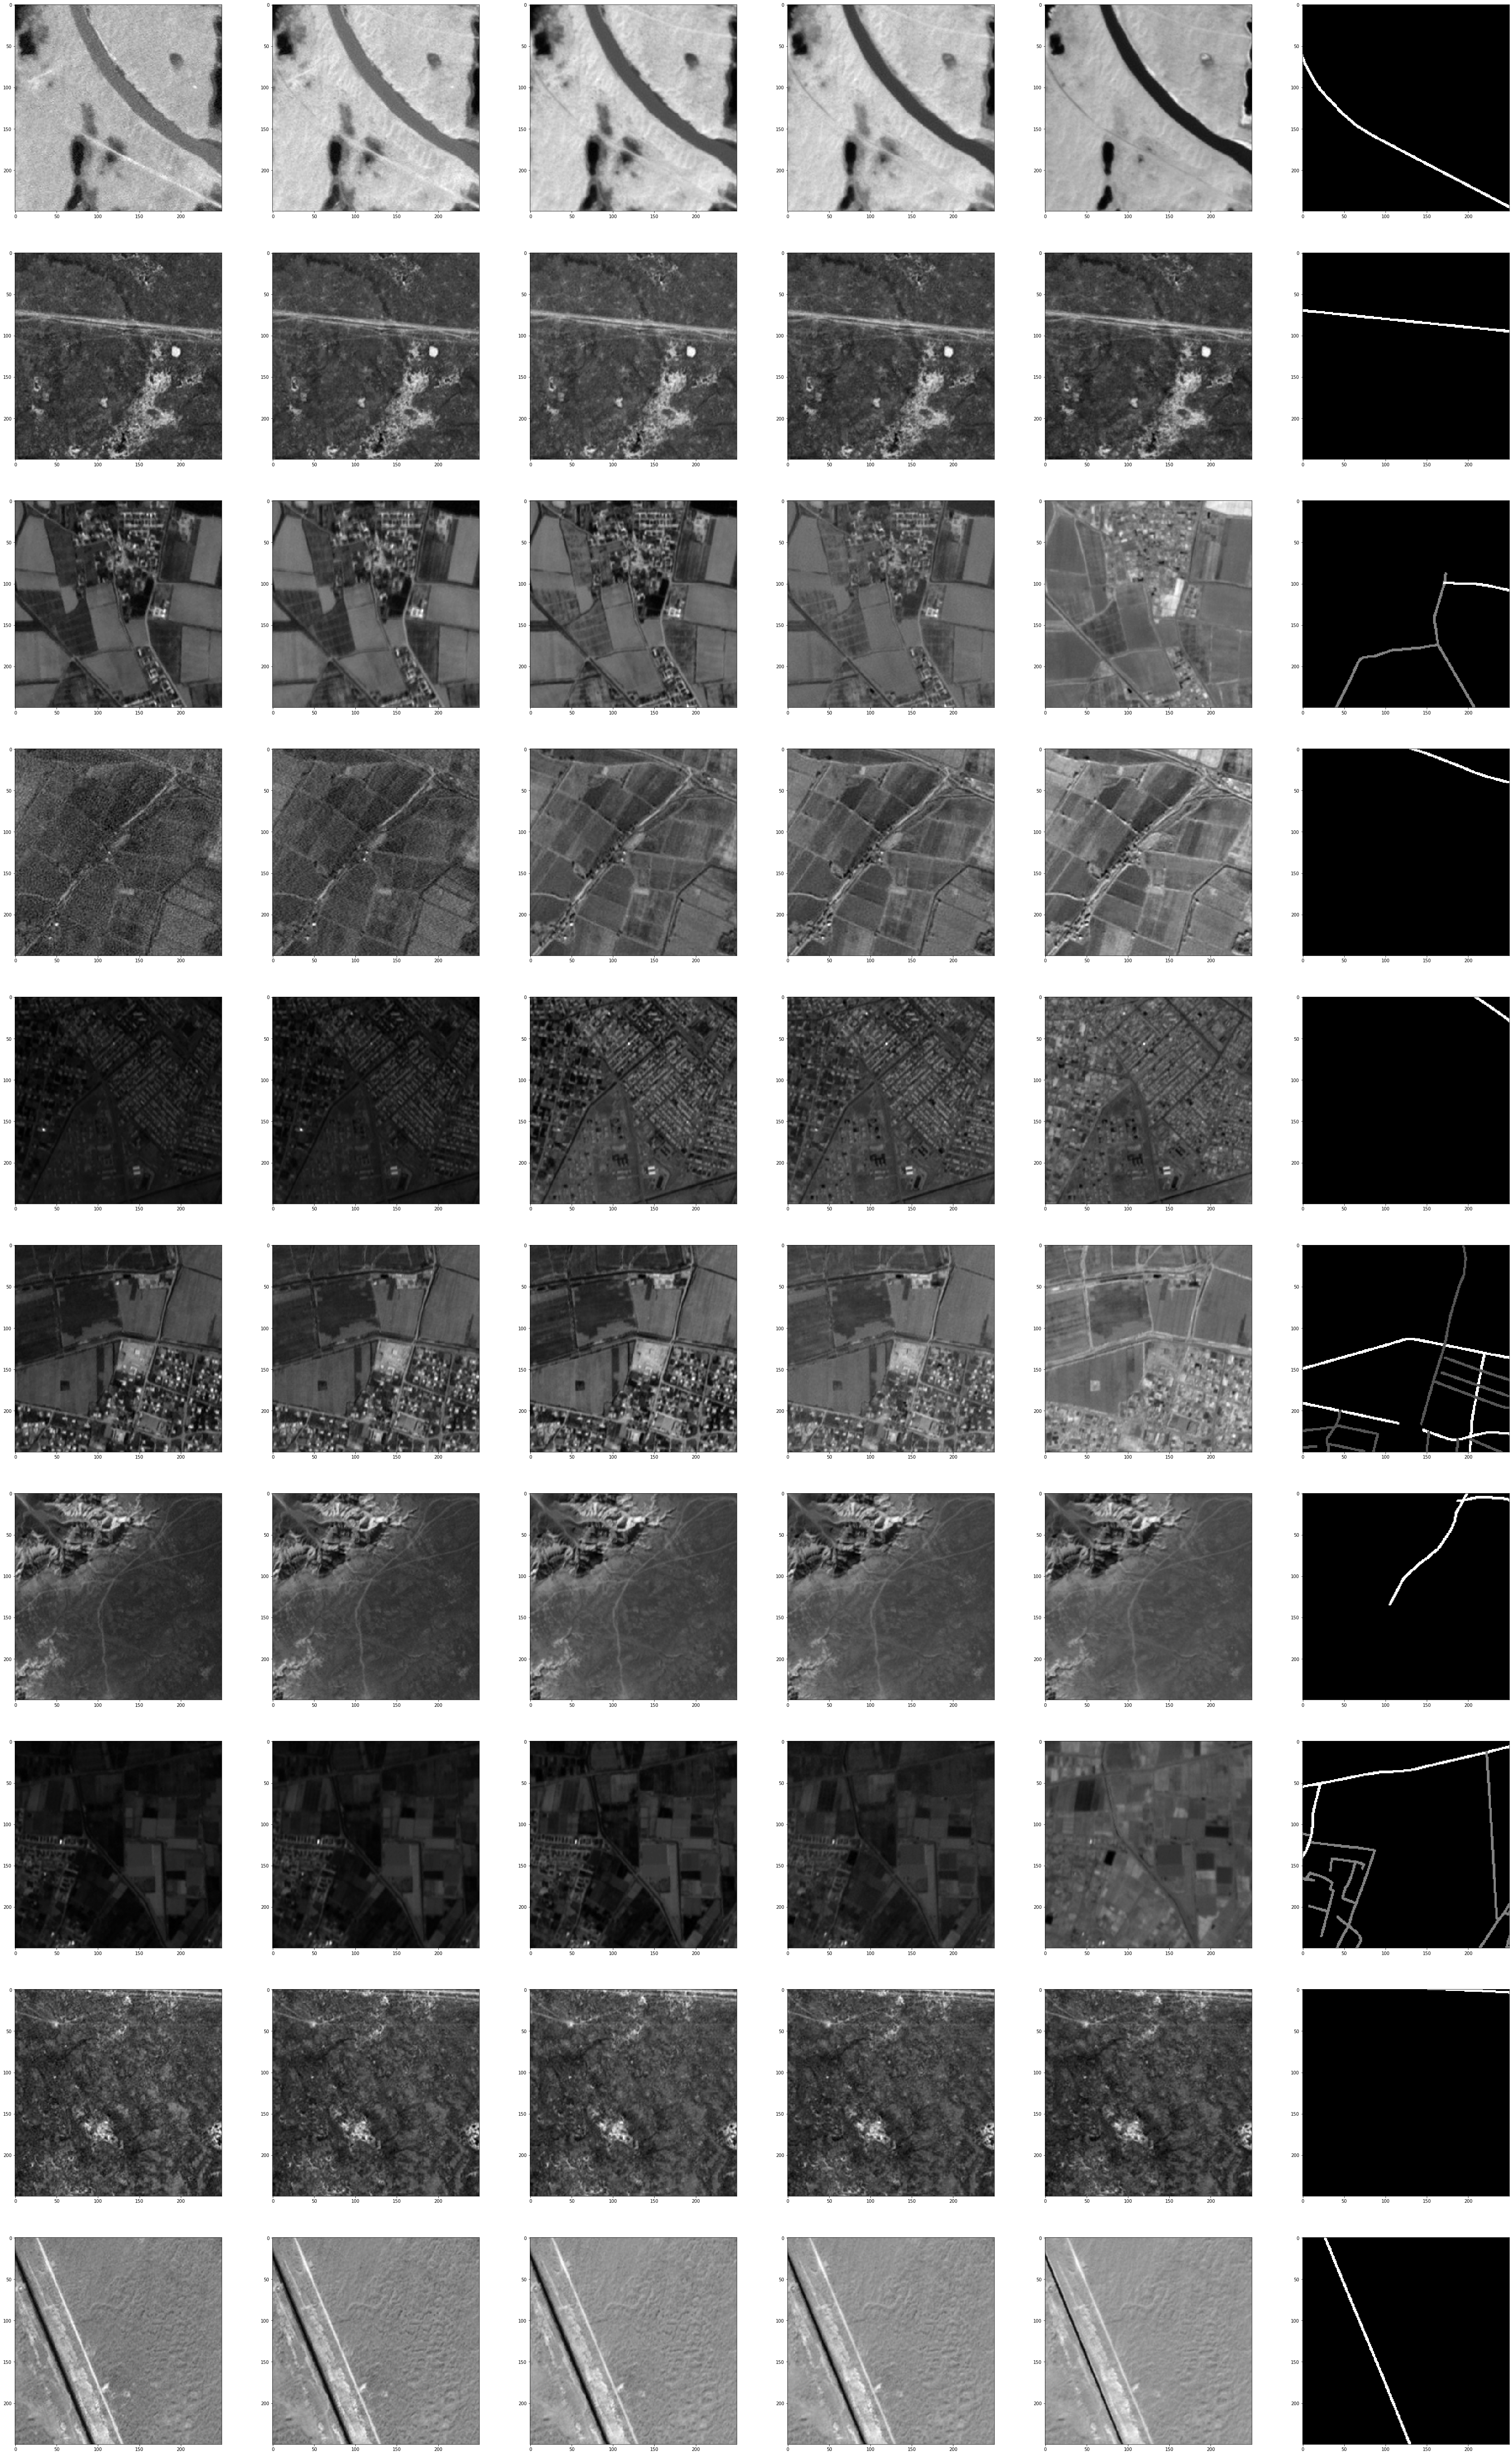

In [43]:
figure(figsize=[60,100])
j=1
for file in glob('smp/*.tif'):
    with ras.open(file) as src:
        I=src.read()
    for i in range(6):
        subplot(10,6,j)
        j+=1
        imshow(I[i,:,:],cmap='gray')

In [45]:
def rescale(I):
    Image=mean(I[:-1,:,:],axis=0)
    V=sort(Image.flatten())
    l=V.shape[0]
    _min=V[int(l/255)]
    _max=V[int((l/255.)*254.)]
    Scaled=(Image-_min)/(_max-_min)
    Scaled[Scaled<=0]=0
    Scaled[Scaled>=1]=1
    Uns8_Image = np.array(Scaled*255,dtype=np.uint8)
    return Uns8_Image

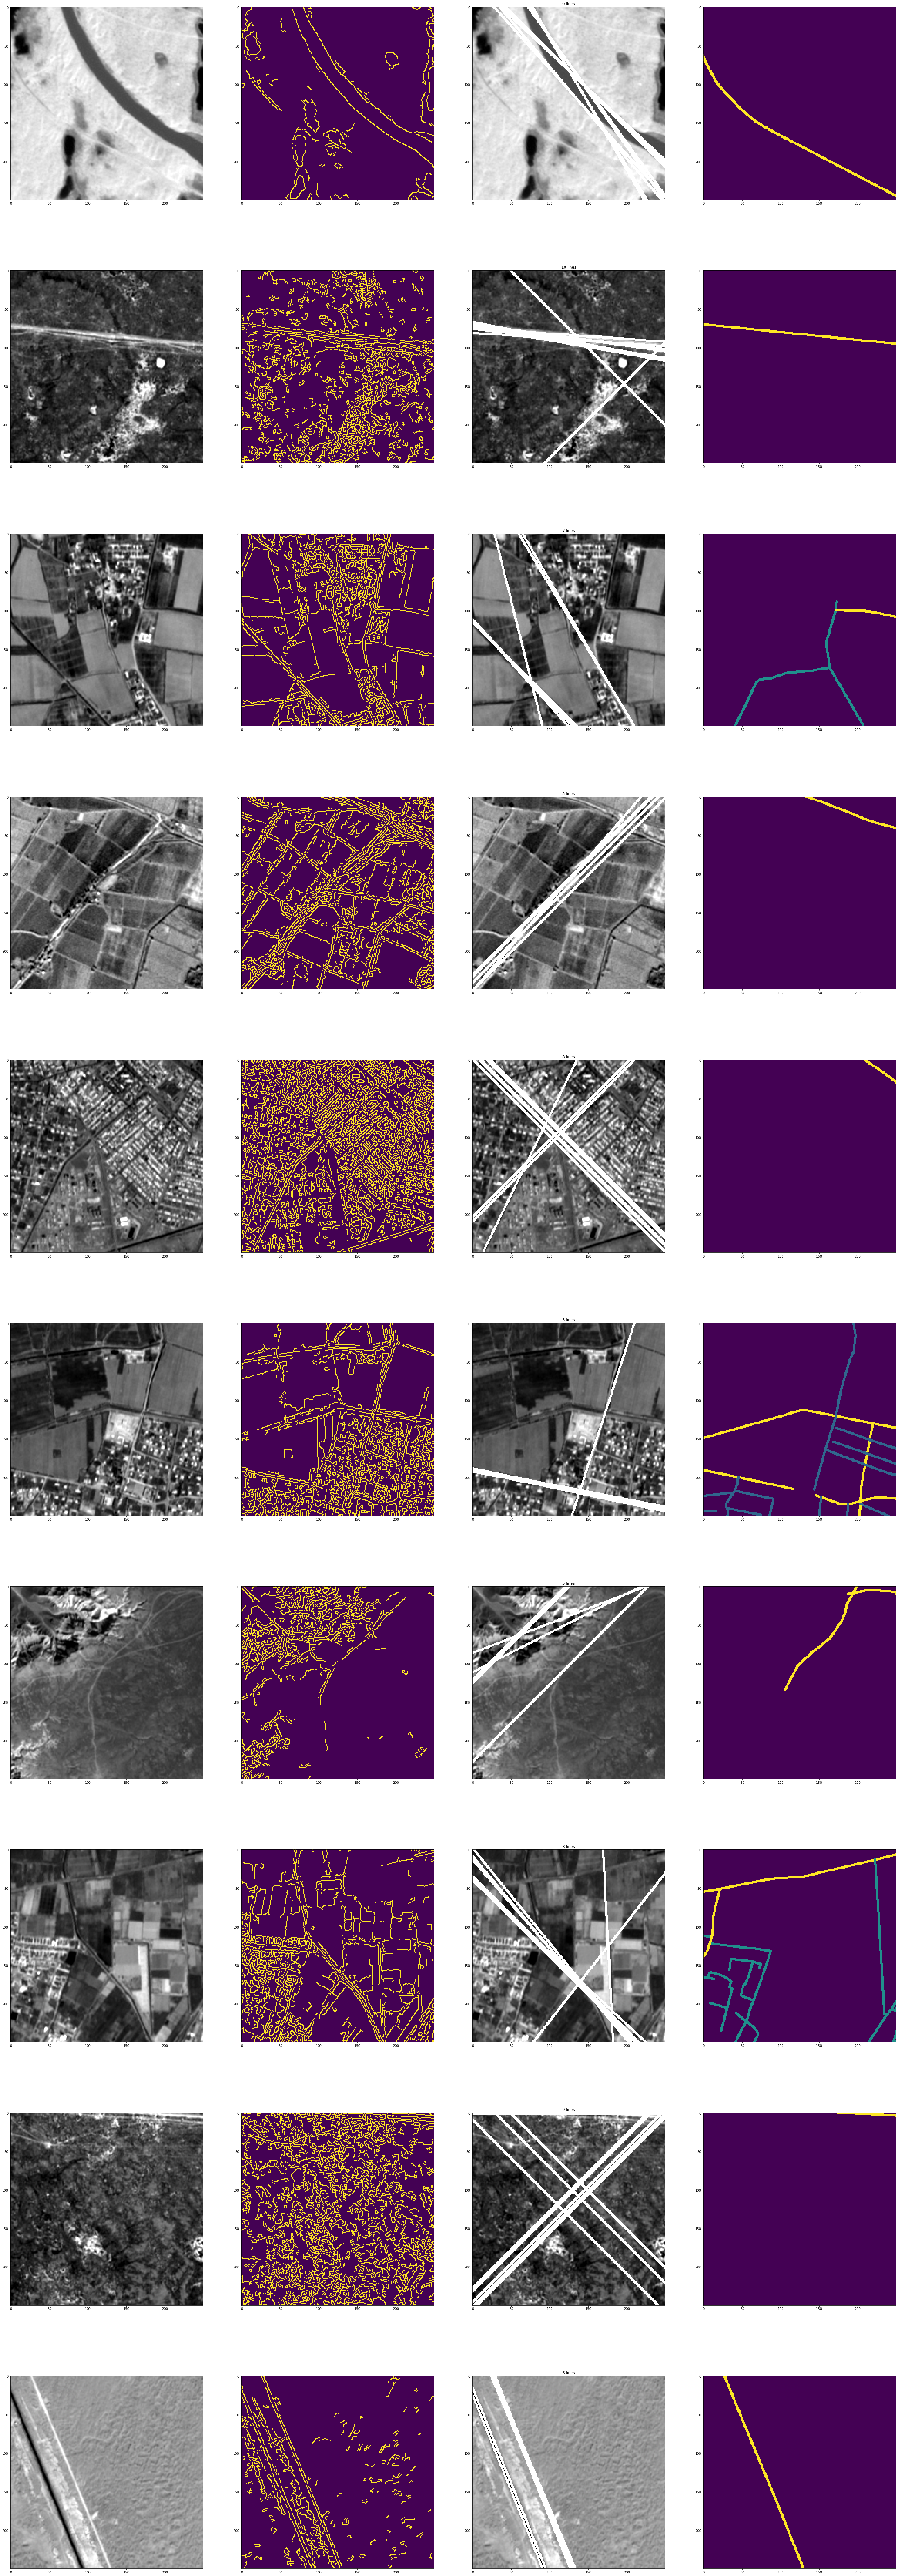

In [113]:
figure(figsize=[50,150])
j=1
col=4
for file in glob('smp/*.tif'):
    with ras.open(file) as src:
        I=src.read()
    scaled=rescale(I)
    subplot(10,col,j)
    imshow(scaled,cmap='gray')
    canny=cv2.Canny(scaled,100,200)
    subplot(10,col,j+1)
    imshow(canny)
    hough,no_lines=Hough(scaled,canny,thr=50)
    subplot(10,col,j+2)
    title('%d lines'%no_lines)
    imshow(hough,cmap='gray')
    subplot(10,col,j+3)
    imshow(I[5,:,:])
    j+=col

In [112]:
def Hough(scaled,canny,thr=50,_min=5,_max=10):
    step=20
    img=copy(scaled)
    while True:
        lines = cv2.HoughLines(canny,1,np.pi/180,int(thr))
        if lines is None:
            L=0
        else:
            L=len(lines)
        if L<=_max and L>=_min:
            break
        if L>_max and sign(step)!=1:
            step=-step/2
        if L<_min and sign(step)!=-1:
            step=-step/2
        thr+=step
        #print(thr,step,L)
        
    for line in lines:
        rho,theta = list(line[0])
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),255,2)

    return img,len(lines)
    #cv2.imwrite('houghlines3.jpg',img)

In [101]:
hough,L=Hough(scaled,canny)

70 20 239
90 20 43
110 20 11
130 20 6


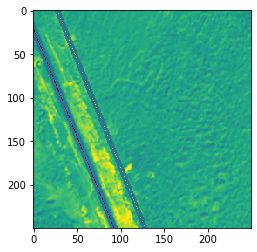

In [102]:
imshow(hough)